Using mps device
Files already downloaded and verified
Model loaded successfully.
Model size: 11.18 million parameters
Accuracy: 0.8064

Classification Report:
airplane: Precision: 0.8051, Recall: 0.8180, F1-score: 0.8115
automobile: Precision: 0.9205, Recall: 0.8910, F1-score: 0.9055
bird: Precision: 0.8103, Recall: 0.7050, F1-score: 0.7540
cat: Precision: 0.7409, Recall: 0.5890, F1-score: 0.6563
deer: Precision: 0.6632, Recall: 0.8900, F1-score: 0.7600
dog: Precision: 0.7912, Recall: 0.6670, F1-score: 0.7238
frog: Precision: 0.8373, Recall: 0.8390, F1-score: 0.8382
horse: Precision: 0.8216, Recall: 0.8750, F1-score: 0.8475
ship: Precision: 0.8667, Recall: 0.8970, F1-score: 0.8816
truck: Precision: 0.8393, Recall: 0.8930, F1-score: 0.8653

Confusion Matrix:
[[818  11  30  10  24   3   8  10  58  28]
 [ 12 891   0   4   7   2   8   2  14  60]
 [ 44   1 705  21 115  24  42  21  12  15]
 [ 30   2  47 589 102 113  52  37  17  11]
 [ 13   2  17  13 890  10  11  41   1   2]
 [ 12   1  29 11

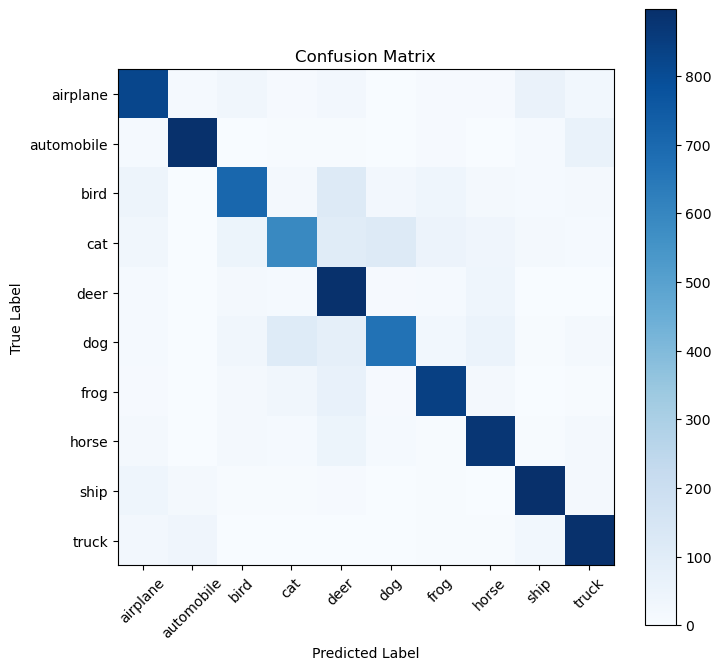


Overall Metrics:
Precision: 0.8096
Recall: 0.8064
F1-score: 0.8044
Time taken for inference: 3.22 seconds


In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
checkpoint = torch.load("cifar10-resnet18.ckpt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("Model loaded successfully.")

model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"Model size: {model_size:.2f} million parameters")
start_time = time.time()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()
time_taken = end_time - start_time

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
for class_name, metrics in report.items():
    if class_name not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"{class_name}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-score: {metrics['f1-score']:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=np.arange(10), labels=test_dataset.classes, rotation=45)
plt.yticks(ticks=np.arange(10), labels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

macro_avg = report["macro avg"]
overall_precision = macro_avg["precision"]
overall_recall = macro_avg["recall"]
overall_f1 = macro_avg["f1-score"]

print("\nOverall Metrics:")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1-score: {overall_f1:.4f}")
print(f"Time taken for inference: {time_taken:.2f} seconds")



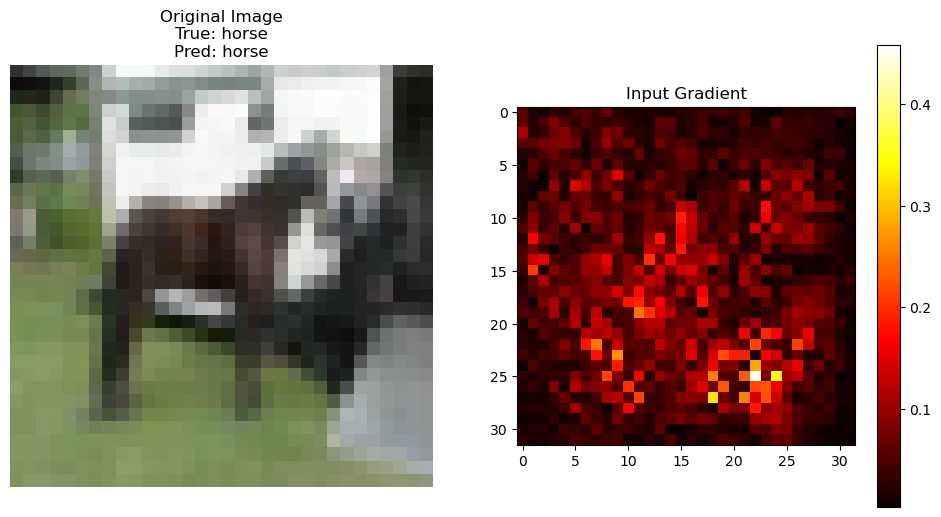

In [20]:
def input_gradient(model, inputs, target_class, device):
    inputs = inputs.to(device).requires_grad_(True)  
    outputs = model(inputs)
    loss = outputs[:, target_class].sum() 
    loss.backward()  
    gradients = inputs.grad.abs().cpu().numpy()  
    return gradients

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

sample_index = 20 
for inputs, labels in test_loader:
    if sample_index < len(inputs): 
        inputs = inputs[sample_index:sample_index + 1] 
        labels = labels[sample_index:sample_index + 1]  
        gradients = input_gradient(model, inputs, labels[0].item(), device) 
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_label = outputs.argmax(dim=1).item() 

        img = denormalize(inputs[0].cpu(), mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(to_pil_image(img)) 
        plt.title(f"Original Image\nTrue: {test_dataset.classes[labels[0].item()]}\nPred: {test_dataset.classes[predicted_label]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gradients[0].sum(axis=0), cmap='hot') 
        plt.title("Input Gradient")
        plt.colorbar()

        plt.show()
        break
    else:
        sample_index -= len(inputs)
